# Manage Directories and Packages

In [1]:
import os
import sys

# Go to main working directory
#os.makedirs('/content/eegnet-charrnn', exist_ok=True)
#%cd /content/eegnet-charrnn

# Directory containing subject files
subject_rawdata_dir = 'raw_data' # All raw .mat files should be here. Make sure to upload them!
subject_chars_dir = 'chars' # Where to store all character data
subject_words_dir = "words" # Where to store all word data

os.makedirs(subject_rawdata_dir, exist_ok=True)
os.makedirs(subject_chars_dir, exist_ok=True)
os.makedirs(subject_words_dir, exist_ok=True)

In [2]:
# Install necessary packages
#!pip install datasets
#!pip install tensorflow==2.8.0
#!pip install mne>=0.17.1 PyRiemann>=0.2.5 scikit-learn>=0.20.1 matplotlib>=2.2.3

#!git clone https://github.com/vlawhern/arl-eegmodels.git
sys.path.append(r'C:\Users\shaoy\arl-eegmodels')

In [3]:
# Import necessary libraries
import numpy as np
import string
import re
import json
import random
import gc
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tqdm import tqdm

from datasets import load_dataset
from scipy.io import loadmat
from scipy.signal import cheby1, filtfilt, resample

from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Create Sequential Character Data

This section will process the SSVEP EEG data from the Benchmark dataset (Tsinghua University) and then use it to create sequences of characters (aka words) for the training and evaluation of deep neural models intending to evaluate their performance on practical word-based data.

In [6]:
# Preprocessing Code from Ruiming
def chebyshev_bandpass(lowcut, highcut, fs, order=4, rp=0.5):
    """
    Design a Chebyshev Type I bandpass filter.

    Parameters:
    - lowcut: Low frequency cut-off for the bandpass filter.
    - highcut: High frequency cut-off for the bandpass filter.
    - fs: Sampling frequency of the EEG data.
    - order: The order of the filter (default: 4).
    - rp: Maximum ripple in the passband (default: 0.5 dB).

    Returns:
    - b, a: Numerator (b) and denominator (a) polynomials of the filter.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = cheby1(order, rp, [low, high], btype='band')
    return b, a

def load_benchmark_data(file_path, n_channels=64, n_timepoints=1500, n_classes=40,
                  lowcut=6.0, highcut=90.0, fs=1000, target_fs=250,
                  window_length=250): # THIS IS CREATING 4s SEGMENTS FOR DATA
    """
    Load EEG data from .mat files in a directory, apply Chebyshev bandpass filter,
    downsample, segment with sliding window, and return as arrays.

    Parameters:
    - file_path: .mat file for specific subject
    - n_channels: Number of EEG channels (default: 64).
    - n_timepoints: Number of time points per trial (default: 1500).
    - n_classes: Number of target classes
    - lowcut: Low frequency cut-off for Chebyshev bandpass filter (default: 6 Hz).
    - highcut: High frequency cut-off for Chebyshev bandpass filter (default: 90 Hz).
    - fs: Original sampling frequency of the EEG data (default: 1000 Hz).
    - target_fs: Target sampling frequency after downsampling (default: 250 Hz).
    - window_length: Length of each segment window in samples (default: 250 samples for 1s at 250 Hz).

    Returns:
    - X: EEG data as a NumPy array with shape (number_of_samples, number_channels, num_timepoints).
    - y: One-hot encoded labels as a NumPy array.
    """
    X, y = [], []
    b, a = chebyshev_bandpass(lowcut, highcut, fs, order=4)  # Define Chebyshev filter

    # Load .mat file
    mat_data = loadmat(file_path)

    # Assuming data is stored in 'data' variable with shape [64, 1500, 40, 6]
    eeg_data = mat_data['data']  # Shape: [64, 1500, 40, 6]

    # Process each trial
    for target_idx in range(eeg_data.shape[2]):
        for block_idx in range(eeg_data.shape[3]):
            trial_data = eeg_data[:, :, target_idx, block_idx]  # Shape: [64, 1500]

            # Apply bandpass filter
            trial_data_filtered = np.zeros_like(trial_data)
            for ch in range(n_channels):
                trial_data_filtered[ch, :] = filtfilt(b, a, trial_data[ch, :])

            # Downsample to target sampling rate
            trial_data_downsampled = resample(trial_data_filtered, int(trial_data_filtered.shape[1] * target_fs / fs), axis=1)

            # Apply sliding window to generate segments
            for start in range(0, trial_data_downsampled.shape[1] - window_length + 1, window_length):
                segment = trial_data_downsampled[:, start:start + window_length]

                # Normalize segment channel-wise
                segment = (segment - segment.mean(axis=1, keepdims=True)) / segment.std(axis=1, keepdims=True)

                # Append the segment and label
                X.append(segment)
                y.append(target_idx)  # Label as the target index

    # Convert lists to NumPy arrays
    X = np.array(X)  # Shape: [num_samples, 64 electrodes, 250 window_length]
    y = np.array(y)  # Shape: [num_samples, 40 classes]

    # Convert labels to one-hot encoding
    y = to_categorical(y, num_classes=n_classes)
    return X, y


In [ ]:
# Test function
X, y = load_benchmark_data("raw_data/S31.mat")
print(X.shape)
print(y.shape)

In [8]:
def create_chars(subject_rawdata_dir, subject_chars_dir):
    """
    Process each subject and save character data into a single file.

    Parameters:
    - subject_rawdata_dir: Directory containing raw subject files (.mat).
    - subject_chars_dir: Directory to save character-specific data.

    Output:
    - Saves a NumPy array for each subject with shape [26, 6, 64, 250].
    """
    all_subject_files = [f for f in os.listdir(subject_rawdata_dir) if f.endswith('.mat')]

    # Process each subject and save character data into a single file
    for subject_file in all_subject_files:
        # Load and preprocess the EEG data for the current subject
        subject_id = subject_file.split('.')[0]  # Get subject identifier (e.g., S1)
        X, y = load_benchmark_data(os.path.join(subject_rawdata_dir, subject_file)) # Shape: [240 samples, 64 channels, 250 time points]

        # Initialize an array to hold all character data
        subject_data = np.zeros((26, 6, 64, 250))  # Shape: [26 characters, 6 blocks, 64 channels, 250 time points]

        # Save the data for each character A-Z in a single array
        for target_idx in range(26):  # Only A-Z targets
            for block_idx in range(6):
              sample_idx = 6*target_idx+block_idx
              assert np.argmax(y[sample_idx]) == target_idx, (
                    f"Mismatch: y[{sample_idx}] (argmax={np.argmax(y[sample_idx])}) != target_idx ({target_idx})"
                )
              subject_data[target_idx, block_idx, :, :] = X[sample_idx, :, :]

        # Save the combined data to a .npy file
        output_file = os.path.join(subject_chars_dir, f'{subject_id}_chars.npy')
        np.save(output_file, subject_data)
        print(f'Saved {output_file}')

In [9]:
# Call function to create character files
create_chars(subject_rawdata_dir, subject_chars_dir)

Saved chars\S1_chars.npy
Saved chars\S10_chars.npy
Saved chars\S11_chars.npy
Saved chars\S12_chars.npy
Saved chars\S13_chars.npy
Saved chars\S14_chars.npy
Saved chars\S15_chars.npy
Saved chars\S16_chars.npy
Saved chars\S17_chars.npy
Saved chars\S18_chars.npy
Saved chars\S19_chars.npy
Saved chars\S2_chars.npy
Saved chars\S20_chars.npy
Saved chars\S21_chars.npy
Saved chars\S22_chars.npy
Saved chars\S23_chars.npy
Saved chars\S24_chars.npy
Saved chars\S25_chars.npy
Saved chars\S26_chars.npy
Saved chars\S27_chars.npy
Saved chars\S28_chars.npy
Saved chars\S29_chars.npy
Saved chars\S3_chars.npy
Saved chars\S30_chars.npy
Saved chars\S31_chars.npy
Saved chars\S32_chars.npy
Saved chars\S33_chars.npy
Saved chars\S34_chars.npy
Saved chars\S35_chars.npy
Saved chars\S4_chars.npy
Saved chars\S5_chars.npy
Saved chars\S6_chars.npy
Saved chars\S7_chars.npy
Saved chars\S8_chars.npy
Saved chars\S9_chars.npy


In [10]:
# Test function
test_chars = np.load("chars/S29_chars.npy")
test_chars.shape

(26, 6, 64, 250)

In [11]:
def create_words(subject_chars_dir, subject_words_dir, word_list, output_name):
    """
    Create words by concatenating random blocks of EEG data for each character in the words for all subjects.

    Parameters:
    - subject_chars_dir: Directory containing character-specific .npy files.
    - subject_words_dir: Directory to save the word-specific dictionary for each subject.
    - word_list: List of words to create.

    Output:
    - Saves a dictionary containing each word as a key and its EEG representation as value for each subject.
    """
    if not os.path.exists(subject_words_dir):
        os.makedirs(subject_words_dir)

    # Process each subject
    all_subject_files = [f for f in os.listdir(subject_chars_dir) if f.endswith('_chars.npy')]

    for subject_file in all_subject_files:
        subject_id = subject_file.split('_')[0]  # Get subject identifier (e.g., S1)

        # Load the character-specific data for the subject
        subject_data = np.load(os.path.join(subject_chars_dir, subject_file))  # Shape: [26, 6, 64, 250]

        # Initialize a dictionary to store the words and their corresponding EEG data
        words_dict = {}

        # Create words by selecting random blocks for each character
        for word in word_list:
            word_data = []
            for char in word.upper():
                if 'A' <= char <= 'Z':
                    char_idx = ord(char) - ord('A')
                    random_block = random.choice(subject_data[char_idx])  # Shape: [64, 250]
                    #random_block = subject_data[char_idx,1,:,:]
                    word_data.append(random_block)
                else:
                    raise ValueError(f"Invalid character '{char}' in word '{word}'. Only A-Z are allowed.")

            # Stack the blocks to form the word
            word_array = np.stack(word_data, axis=0)  # Shape: [word_length, 64, 250]
            words_dict[word] = word_array

        # Save the dictionary to a .npy file
        output_file = os.path.join(subject_words_dir, f'{subject_id}_{output_name}.npy')
        np.save(output_file, words_dict)
        print(f'Saved word dictionary for subject {subject_id} to {output_file}')

In [14]:
def is_valid_word(word):
    # Exclude single letters except "i" and "a"
    if len(word) == 1 and word not in {'i', 'a'}:
        return False

    # Exclude prefixes and suffixes
    prefixes_suffixes = {
        'de', 're', 'un', 'pre', 'inter', 'anti', 'ex',
        'in', 'dis', 'non', 'mis', 'co',
        'able', 'ible', 'al', 'ance', 'ence', 'dom', 'er', 'or', 'ist', 'ism',
        'ity', 'ty', 'ment', 'ness', 'en', 'ful', 'ous', 'ious', 'eous', 'ish',
        'ive', 'ative', 'itive', 'ly', 'ed', 'ing', 'tion', 'ation', 'sion'
    }

    # Check if the word matches any prefix or suffix
    if word.lower() in prefixes_suffixes:
        return False

    # Allow the word if it passes all checks
    return True

In [15]:
# Load word frequency list from Google Web Trillion Text Corpus
word_freq_list = pd.read_csv("word_freq/unigram_freq.csv")

# Clean list of non-words
word_freq_list = word_freq_list.dropna(subset=['word'])
word_freq_list = word_freq_list[word_freq_list['word'].apply(is_valid_word)]

# List 1: Top 100 most common words (no conditions)
top100_commonwords = word_freq_list.head(100)['word'].tolist()

# List 2: Top 100 most common words with at least 7 letters
top100_longwords = word_freq_list[word_freq_list['word'].str.len() >= 7].head(100)['word'].tolist()

# List 3: Top 1000 most common words (no conditions)
lotsofwords = word_freq_list.head(1000)['word'].tolist()

# Print the lists
print("Top 100 Common Words:")
print(top100_commonwords)
print("\nTop 100 Long Words (>= 7 letters):")
print(top100_longwords)
print("\nTop 1000 Common Words:")
print(lotsofwords)


Top 100 Common Words:
['the', 'of', 'and', 'to', 'a', 'for', 'is', 'on', 'that', 'by', 'this', 'with', 'i', 'you', 'it', 'not', 'be', 'are', 'from', 'at', 'as', 'your', 'all', 'have', 'new', 'more', 'an', 'was', 'we', 'will', 'home', 'can', 'us', 'about', 'if', 'page', 'my', 'has', 'search', 'free', 'but', 'our', 'one', 'other', 'do', 'no', 'information', 'time', 'they', 'site', 'he', 'up', 'may', 'what', 'which', 'their', 'news', 'out', 'use', 'any', 'there', 'see', 'only', 'so', 'his', 'when', 'contact', 'here', 'business', 'who', 'web', 'also', 'now', 'help', 'get', 'pm', 'view', 'online', 'first', 'am', 'been', 'would', 'how', 'were', 'me', 'services', 'some', 'these', 'click', 'its', 'like', 'service', 'than', 'find', 'price', 'date', 'back', 'top', 'people', 'had']

Top 100 Long Words (>= 7 letters):
['information', 'contact', 'business', 'services', 'service', 'products', 'product', 'available', 'copyright', 'support', 'message', 'software', 'through', 'privacy', 'company', 'gen

In [16]:
# Create corresponding files
create_words(subject_chars_dir=subject_chars_dir, subject_words_dir=subject_words_dir, word_list=top100_commonwords, output_name="commonwords")

Saved word dictionary for subject S10 to words\S10_commonwords.npy
Saved word dictionary for subject S11 to words\S11_commonwords.npy
Saved word dictionary for subject S12 to words\S12_commonwords.npy
Saved word dictionary for subject S13 to words\S13_commonwords.npy
Saved word dictionary for subject S14 to words\S14_commonwords.npy
Saved word dictionary for subject S15 to words\S15_commonwords.npy
Saved word dictionary for subject S16 to words\S16_commonwords.npy
Saved word dictionary for subject S17 to words\S17_commonwords.npy
Saved word dictionary for subject S18 to words\S18_commonwords.npy
Saved word dictionary for subject S19 to words\S19_commonwords.npy
Saved word dictionary for subject S1 to words\S1_commonwords.npy
Saved word dictionary for subject S20 to words\S20_commonwords.npy
Saved word dictionary for subject S21 to words\S21_commonwords.npy
Saved word dictionary for subject S22 to words\S22_commonwords.npy
Saved word dictionary for subject S23 to words\S23_commonwords.n

In [17]:
# Create corresponding files
create_words(subject_chars_dir=subject_chars_dir, subject_words_dir=subject_words_dir, word_list=top100_longwords, output_name="longwords")

Saved word dictionary for subject S10 to words\S10_longwords.npy
Saved word dictionary for subject S11 to words\S11_longwords.npy
Saved word dictionary for subject S12 to words\S12_longwords.npy
Saved word dictionary for subject S13 to words\S13_longwords.npy
Saved word dictionary for subject S14 to words\S14_longwords.npy
Saved word dictionary for subject S15 to words\S15_longwords.npy
Saved word dictionary for subject S16 to words\S16_longwords.npy
Saved word dictionary for subject S17 to words\S17_longwords.npy
Saved word dictionary for subject S18 to words\S18_longwords.npy
Saved word dictionary for subject S19 to words\S19_longwords.npy
Saved word dictionary for subject S1 to words\S1_longwords.npy
Saved word dictionary for subject S20 to words\S20_longwords.npy
Saved word dictionary for subject S21 to words\S21_longwords.npy
Saved word dictionary for subject S22 to words\S22_longwords.npy
Saved word dictionary for subject S23 to words\S23_longwords.npy
Saved word dictionary for s

In [18]:
# Create corresponding files
create_words(subject_chars_dir=subject_chars_dir, subject_words_dir=subject_words_dir, word_list=lotsofwords, output_name="lotsofwords")

Saved word dictionary for subject S10 to words\S10_lotsofwords.npy
Saved word dictionary for subject S11 to words\S11_lotsofwords.npy
Saved word dictionary for subject S12 to words\S12_lotsofwords.npy
Saved word dictionary for subject S13 to words\S13_lotsofwords.npy
Saved word dictionary for subject S14 to words\S14_lotsofwords.npy
Saved word dictionary for subject S15 to words\S15_lotsofwords.npy
Saved word dictionary for subject S16 to words\S16_lotsofwords.npy
Saved word dictionary for subject S17 to words\S17_lotsofwords.npy
Saved word dictionary for subject S18 to words\S18_lotsofwords.npy
Saved word dictionary for subject S19 to words\S19_lotsofwords.npy
Saved word dictionary for subject S1 to words\S1_lotsofwords.npy
Saved word dictionary for subject S20 to words\S20_lotsofwords.npy
Saved word dictionary for subject S21 to words\S21_lotsofwords.npy
Saved word dictionary for subject S22 to words\S22_lotsofwords.npy
Saved word dictionary for subject S23 to words\S23_lotsofwords.n

In [19]:
# This is a test word that contains every letter in the alphabet 6 times
test_word = [''.join([letter * 6 for letter in string.ascii_uppercase])]
test_word

['AAAAAABBBBBBCCCCCCDDDDDDEEEEEEFFFFFFGGGGGGHHHHHHIIIIIIJJJJJJKKKKKKLLLLLLMMMMMMNNNNNNOOOOOOPPPPPPQQQQQQRRRRRRSSSSSSTTTTTTUUUUUUVVVVVVWWWWWWXXXXXXYYYYYYZZZZZZ']

# Char-RNN Model

## Use Wiki Dataset

In [20]:
# Load the WikiText-2 dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
# loading from Hugging Face datasets

# Access the training data
train_text = dataset['train']['text']

# Combine the text into a single string
raw_text = ' '.join(train_text)

# Preprocess the text (remove non-alphaetic characters and convert everything to uppercase)
processed_text = re.sub(r'[^a-zA-Z ]+', '', raw_text.upper())

# Remove extra spaces
processed_text = re.sub(r'\s+', ' ', processed_text).strip()

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [21]:
# Display the length and a sample of the processed text
print(f"Processed text length: {len(processed_text)} characters")
print(f"Sample text: {processed_text[500:1000]}")

Processed text length: 9934567 characters
Sample text: TARY UNIT SERVING THE NATION OF GALLIA DURING THE SECOND EUROPAN WAR WHO PERFORM SECRET BLACK OPERATIONS AND ARE PITTED AGAINST THE IMPERIAL UNIT CALAMATY RAVEN THE GAME BEGAN DEVELOPMENT IN CARRYING OVER A LARGE PORTION OF THE WORK DONE ON VALKYRIA CHRONICLES II WHILE IT RETAINED THE STANDARD FEATURES OF THE SERIES IT ALSO UNDERWENT MULTIPLE ADJUSTMENTS SUCH AS MAKING THE GAME MORE FORGIVING FOR SERIES NEWCOMERS CHARACTER DESIGNER RAITA HONJOU AND COMPOSER HITOSHI SAKIMOTO BOTH RETURNED FROM PR


In [22]:
print(f"Sample text: {processed_text[2000:2500]}")

Sample text: EAKING PARTIALLY THROUGH VOICED SPEECH BUBBLES AND PARTIALLY THROUGH UNVOICED TEXT THE PLAYER PROGRESSES THROUGH A SERIES OF LINEAR MISSIONS GRADUALLY UNLOCKED AS MAPS THAT CAN BE FREELY SCANNED THROUGH AND REPLAYED AS THEY ARE UNLOCKED THE ROUTE TO EACH STORY LOCATION ON THE MAP VARIES DEPENDING ON AN INDIVIDUAL PLAYER S APPROACH WHEN ONE OPTION IS SELECTED THE OTHER IS SEALED OFF TO THE PLAYER OUTSIDE MISSIONS THE PLAYER CHARACTERS REST IN A CAMP WHERE UNITS CAN BE CUSTOMIZED AND CHARACTER GRO


In [23]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length):
        self.text = text
        self.seq_length = seq_length
        # Sort characters such that 'A-Z' come first, followed by space
        sorted_chars = sorted(set(text) - {' '}) + [' ']
        self.char2idx = {ch: i for i, ch in enumerate(sorted_chars)}
        self.idx2char = {i: ch for ch, i in self.char2idx.items()}
        self.vocab_size = len(self.char2idx)

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        chunk = self.text[idx : idx + self.seq_length + 1]
        input_text = chunk[:-1]
        target_text = chunk[1:]
        input_tensor = torch.tensor([self.char2idx[ch] for ch in input_text], dtype=torch.long)
        target_tensor = torch.tensor([self.char2idx[ch] for ch in target_text], dtype=torch.long)
        return input_tensor, target_tensor

In [24]:
# Initialize the dataset and dataloader
seq_length = 20
dataset = CharDataset(processed_text, seq_length)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(f"Vocabulary size: {dataset.vocab_size}")
print(f"Mapping: {list(dataset.char2idx.items())[:]}")

Vocabulary size: 27
Mapping: [('A', 0), ('B', 1), ('C', 2), ('D', 3), ('E', 4), ('F', 5), ('G', 6), ('H', 7), ('I', 8), ('J', 9), ('K', 10), ('L', 11), ('M', 12), ('N', 13), ('O', 14), ('P', 15), ('Q', 16), ('R', 17), ('S', 18), ('T', 19), ('U', 20), ('V', 21), ('W', 22), ('X', 23), ('Y', 24), ('Z', 25), (' ', 26)]


In [25]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(CharRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.rnn(x, hidden)
        output = self.layer_norm(output)
        output = self.dropout(output)
        logits = self.fc(output)
        return logits, hidden

In [26]:
embedding_dim = 128
hidden_dim = 256
num_layers = 2
num_epochs = 3
lr = 1e-3

# Initialize the model, loss, optimizer, and scheduler
charrnn_model = CharRNN(dataset.vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(charrnn_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)

In [27]:
# Training loop
torch.cuda.empty_cache()
gc.collect()

for epoch in range(num_epochs):
    charrnn_model.train()
    epoch_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = charrnn_model(inputs)
        loss = criterion(outputs.view(-1, dataset.vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

Epoch [1/3], Loss: 1.3814
Learning Rate: 0.000775


Epoch [2/3], Loss: 1.3262
Learning Rate: 0.000325


Epoch [3/3], Loss: 1.3015
Learning Rate: 0.000100


In [30]:
# Save model
torch.save(charrnn_model.state_dict(), "better_charrnn_weights.pth")
torch.save(dataset.char2idx, "better_charrnn_char2idx.pth")

In [31]:
# Load model
charrnn_model.load_state_dict(torch.load("better_charrnn_weights.pth"))
char2idx = torch.load("better_charrnn_char2idx.pth")

C:\Users\shaoy\AppData\Local\Temp\ipykernel_24888\2043924090.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  charrnn_model.load_state_dict(torch.load("better_charrnn_wei

In [32]:
def predict_next_char(model, char2idx, input_text):
    model.eval()
    input_text = input_text.upper() # All inputs should be capital letters and space
    input_tensor = torch.tensor([char2idx[ch] for ch in input_text], dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        logits, _ = model(input_tensor)
        probs = torch.softmax(logits[:, -1, :], dim=-1)  # Softmax over the last character in the sequence
        next_char_idx = torch.argmax(probs).item()  # Index of the most probable character
        confidence = probs[0, next_char_idx].item()  # Confidence (probability) of the predicted character
        next_char = [ch for ch, idx in char2idx.items() if idx == next_char_idx][0] # Map index to char

    return next_char, confidence

In [33]:
# Test CharRNN model on single inputs
start_text = "FLEXIBL"
next_char, confidence = predict_next_char(charrnn_model, char2idx, start_text)

print(f"Input: {start_text}")
print(f"Predicted next character: {next_char}")
print(f"Confidence: {confidence:.4f}")

Input: FLEXIBL
Predicted next character: E
Confidence: 0.9928


In [34]:
def evaluate_model_on_words(model, char2idx, word_list):
    total_correct_chars = 0
    total_chars = 0

    for word in word_list:
        word = word.upper() # All inputs should be capital letters and space
        correct_chars = 0

        for i in range(1, len(word)):
            input_text = word[:i]  # Provide the first i characters as input
            target_char = word[i]  # The next character to predict
            predicted_char, _ = predict_next_char(model, char2idx, input_text)

            if predicted_char == target_char:
                correct_chars += 1

        total_correct_chars += correct_chars
        total_chars += len(word) - 1  # Exclude the first character

    accuracy = total_correct_chars / total_chars if total_chars > 0 else 0
    return accuracy


In [35]:
# Test CharRNN on entire word set
word_set_accuracy = evaluate_model_on_words(charrnn_model, char2idx, lotsofwords)
print(f"Evaluation Accuracy: {word_set_accuracy:.4f}")

Evaluation Accuracy: 0.4876


# EEGNet

In [4]:
# Creating an EEGNet model
#eegnet_model = EEGNet(nb_classes=40, Chans=64, Samples=250, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')
eegnet_model = EEGNet(nb_classes=40, Chans=64, Samples=250, dropoutRate=0.2, kernLength=64, F1=16, D=2, F2=32, dropoutType='Dropout')

eegnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

eegnet_model.summary()

C:\Users\shaoy\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 250, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 250, 16)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 250, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 1, 250, 32)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 250, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1, 250, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 1, 62, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 62, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 1, 62, 32)           │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 62, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1, 62, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 1, 7, 32)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │           9,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Activation)                 │ (None, 40)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,928 (54.41 KB)

 Trainable params: 13,768 (53.78 KB)

 Non-trainable params: 160 (640.00 B)

In [7]:
# Get training data
X_all, y_all = [], []

# Iterate through each file in the directory
for file_name in os.listdir(subject_rawdata_dir):
    if file_name.endswith('.mat'):
        print(f'Processing file: {file_name}')
        file_path = os.path.join(subject_rawdata_dir, file_name)
        X_single, y_single = load_benchmark_data(file_path)
        X_all.append(X_single)
        y_all.append(y_single)

# Concatenate all the data
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

print(f"Combined X shape: {X_all.shape}")
print(f"Combined y shape: {y_all.shape}")

Processing file: S1.mat
Processing file: S10.mat
Processing file: S11.mat
Processing file: S12.mat
Processing file: S13.mat
Processing file: S14.mat
Processing file: S15.mat
Processing file: S16.mat
Processing file: S17.mat
Processing file: S18.mat
Processing file: S19.mat
Processing file: S2.mat
Processing file: S20.mat
Processing file: S21.mat
Processing file: S22.mat
Processing file: S23.mat
Processing file: S24.mat
Processing file: S25.mat
Processing file: S26.mat
Processing file: S27.mat
Processing file: S28.mat
Processing file: S29.mat
Processing file: S3.mat
Processing file: S30.mat
Processing file: S31.mat
Processing file: S32.mat
Processing file: S33.mat
Processing file: S34.mat
Processing file: S35.mat
Processing file: S4.mat
Processing file: S5.mat
Processing file: S6.mat
Processing file: S7.mat
Processing file: S8.mat
Processing file: S9.mat
Combined X shape: (8400, 64, 250)
Combined y shape: (8400, 40)


In [8]:
split_index = int(0.9 * X_all.shape[0])

# manually split the dataset into test and train (all)
X_test = X_all[split_index:]
y_test = y_all[split_index:]

X_all = X_all[:split_index]
y_all = y_all[:split_index]

print('Train shapes:', X_all.shape, y_all.shape)
print('Test shapes:', X_test.shape, y_test.shape)

Train shapes: (7560, 64, 250) (7560, 40)
Test shapes: (840, 64, 250) (840, 40)


In [9]:
# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Initialize lists to store validation scores for each fold
val_losses = []
val_accuracies = []
initializer = RandomNormal(mean=0.0, stddev=0.1)
# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(X_all)):
    print(f"Training fold {fold + 1}...")

    # Split data into training and validation sets for this fold
    X_train, X_val = X_all[train_index], X_all[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]

    history = eegnet_model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1,
                        validation_data=(X_val, y_val))

    # Get the final validation loss and accuracy for this fold
    loss = history.history['val_loss'][-1]
    accuracy = history.history['val_accuracy'][-1]


    # Store the results
    val_losses.append(loss)
    val_accuracies.append(accuracy)

    print(f"Fold {fold + 1} - Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    break # End at first fold

# Calculate average performance across all folds
avg_loss = np.mean(val_losses)
avg_accuracy = np.mean(val_accuracies)

print(f"\n10-Fold Cross-Validation Results:")
print(f"Average Validation Loss: {avg_loss:.4f}")
print(f"Average Validation Accuracy: {avg_accuracy:.4f}")

Training fold 1...
Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - accuracy: 0.0461 - loss: 3.5824 - val_accuracy: 0.0794 - val_loss: 3.3327
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 32s 150ms/step - accuracy: 0.1730 - loss: 2.8204 - val_accuracy: 0.3876 - val_loss: 2.3090
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - accuracy: 0.3980 - loss: 2.2148 - val_accuracy: 0.5040 - val_loss: 1.8280
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 128ms/step - accuracy: 0.5320 - loss: 1.8780 - val_accuracy: 0.6918 - val_loss: 1.5068
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 127ms/step - accuracy: 0.6231 - loss: 1.6615 - val_accuracy: 0.7407 - val_loss: 1.3197
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.6826 - loss: 1.4963 - val_accuracy: 0.7526 - val_loss: 1.2180
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.6816 - loss: 1.4154 - val_accuracy: 0.7685 - val_loss: 1.1670
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step -

In [41]:
# Save current model
eegnet_model.save_weights("first_try_no_aug.weights.h5")

In [84]:
eegnet_model.load_weights("first_try_no_aug.weights.h5")

In [10]:
# Test that model is working
#loss, accuracy = eegnet_model.evaluate(X_all, y_all, batch_size=1, verbose=1)
loss, accuracy = eegnet_model.evaluate(X_test, y_test, batch_size=1, verbose=1)

#print(f"Validation Loss: {loss:.4f}")
#print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

840/840 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8901 - loss: 0.3614
Test Loss: 0.5043
Test Accuracy: 0.8488


In [12]:
print(val_losses)
print(val_accuracies)

[0.43817681074142456]
[0.8743386268615723]


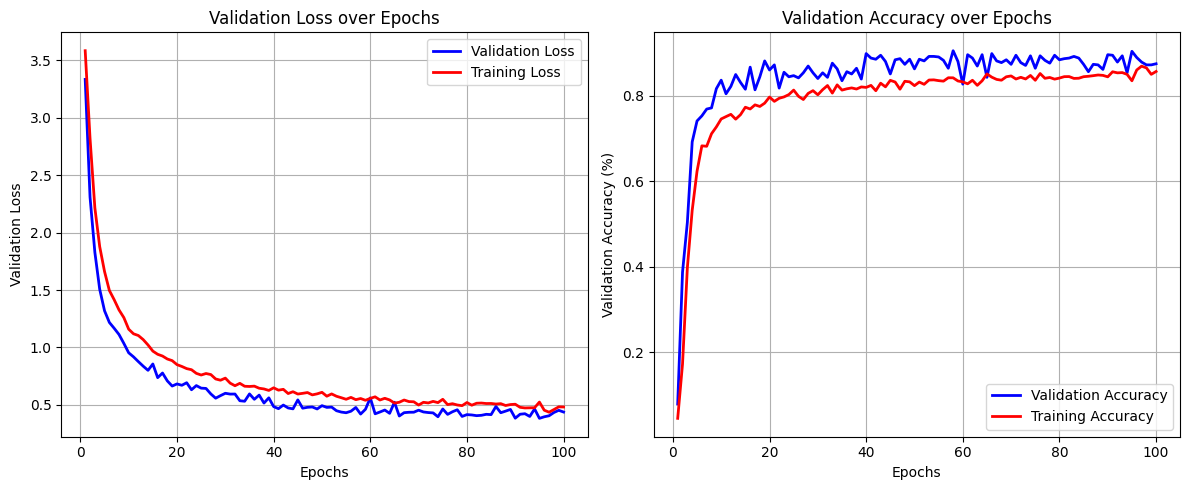

In [17]:
import matplotlib.pyplot as plt


train_accuracies = [
    0.0461, 0.1730, 0.3980, 0.5320, 0.6231, 0.6826, 0.6816, 0.7109, 0.7268, 0.7454,
    0.7509, 0.7562, 0.7449, 0.7554, 0.7728, 0.7687, 0.7783, 0.7746, 0.7823, 0.7966,
    0.7865, 0.7937, 0.7969, 0.8023, 0.8128, 0.7983, 0.7908, 0.8051, 0.8115, 0.8019,
    0.8138, 0.8235, 0.8058, 0.8250, 0.8128, 0.8158, 0.8179, 0.8153, 0.8202, 0.8191,
    0.8238, 0.8114, 0.8289, 0.8204, 0.8356, 0.8317, 0.8149, 0.8334, 0.8321, 0.8232,
    0.8316, 0.8263, 0.8363, 0.8367, 0.8349, 0.8337, 0.8416, 0.8415, 0.8341, 0.8320,
    0.8275, 0.8358, 0.8239, 0.8345, 0.8506, 0.8430, 0.8378, 0.8359, 0.8439, 0.8459,
    0.8387, 0.8427, 0.8388, 0.8470, 0.8358, 0.8515, 0.8404, 0.8423, 0.8384, 0.8409,
    0.8442, 0.8444, 0.8401, 0.8405, 0.8441, 0.8451, 0.8465, 0.8481, 0.8472, 0.8438,
    0.8556, 0.8531, 0.8537, 0.8496, 0.8346, 0.8598, 0.8687, 0.8647, 0.8496, 0.8563
]
val_accuracies = [
    0.0794, 0.3876, 0.5040, 0.6918, 0.7407, 0.7526, 0.7685, 0.7712, 0.8161, 0.8360, 
    0.8042, 0.8214, 0.8492, 0.8307, 0.8148, 0.8664, 0.8135, 0.8439, 0.8810, 0.8598, 
    0.8717, 0.8175, 0.8545, 0.8439, 0.8466, 0.8413, 0.8532, 0.8690, 0.8532, 0.8399, 
    0.8532, 0.8426, 0.8757, 0.8624, 0.8347, 0.8558, 0.8505, 0.8638, 0.8386, 0.8981, 
    0.8876, 0.8849, 0.8942, 0.8796, 0.8505, 0.8836, 0.8862, 0.8730, 0.8849, 0.8624, 
    0.8849, 0.8810, 0.8915, 0.8915, 0.8902, 0.8823, 0.8638, 0.9048, 0.8796, 0.8267, 
    0.8955, 0.8876, 0.8690, 0.8955, 0.8426, 0.8981, 0.8810, 0.8770, 0.8836, 0.8730, 
    0.8942, 0.8770, 0.8704, 0.8929, 0.8638, 0.8929, 0.8823, 0.8757, 0.8942, 0.8836, 
    0.8862, 0.8876, 0.8915, 0.8876, 0.8730, 0.8558, 0.8730, 0.8717, 0.8611, 0.8955, 
    0.8942, 0.8783, 0.8929, 0.8532, 0.9034, 0.8889, 0.8783, 0.8717, 0.8717, 0.8743
]

train_losses = [
    3.5824, 2.8204, 2.2148, 1.8780, 1.6615, 1.4963, 1.4154, 1.3267, 1.2599, 1.1592,
    1.1190, 1.1041, 1.0687, 1.0219, 0.9684, 0.9407, 0.9255, 0.8997, 0.8855, 0.8507,
    0.8349, 0.8161, 0.8064, 0.7749, 0.7604, 0.7735, 0.7644, 0.7260, 0.7152, 0.7334,
    0.6897, 0.6672, 0.6880, 0.6626, 0.6607, 0.6636, 0.6454, 0.6392, 0.6262, 0.6491,
    0.6286, 0.6358, 0.5992, 0.6152, 0.5949, 0.6010, 0.6079, 0.5875, 0.5965, 0.6098,
    0.5760, 0.5959, 0.5756, 0.5629, 0.5493, 0.5658, 0.5460, 0.5560, 0.5405, 0.5571,
    0.5706, 0.5430, 0.5578, 0.5437, 0.5160, 0.5233, 0.5429, 0.5292, 0.5276, 0.4991,
    0.5230, 0.5174, 0.5310, 0.5202, 0.5491, 0.5030, 0.5108, 0.4996, 0.4937, 0.5211,
    0.4977, 0.5148, 0.5165, 0.5123, 0.5128, 0.5079, 0.5112, 0.4950, 0.5034, 0.5062,
    0.4792, 0.4739, 0.4749, 0.4760, 0.5249, 0.4541, 0.4370, 0.4597, 0.4835, 0.4822
]
val_losses = [
    3.3327, 2.3090, 1.8280, 1.5068, 1.3197, 1.2180, 1.1670, 1.1128, 1.0354, 0.9538, 
    0.9184, 0.8771, 0.8375, 0.8011, 0.8565, 0.7374, 0.7778, 0.7091, 0.6644, 0.6829, 
    0.6711, 0.6933, 0.6322, 0.6684, 0.6462, 0.6437, 0.5958, 0.5588, 0.5809, 0.6015, 
    0.5944, 0.5950, 0.5366, 0.5322, 0.5959, 0.5491, 0.5856, 0.5165, 0.5618, 0.4855, 
    0.4675, 0.4989, 0.4737, 0.4659, 0.5439, 0.4718, 0.4793, 0.4823, 0.4650, 0.4937, 
    0.4787, 0.4813, 0.4497, 0.4379, 0.4321, 0.4455, 0.4782, 0.4207, 0.4623, 0.5611, 
    0.4228, 0.4386, 0.4557, 0.4270, 0.5237, 0.4037, 0.4327, 0.4362, 0.4368, 0.4545, 
    0.4389, 0.4337, 0.4307, 0.3973, 0.4648, 0.4180, 0.4406, 0.4580, 0.4000, 0.4157, 
    0.4129, 0.4067, 0.4098, 0.4184, 0.4158, 0.4867, 0.4323, 0.4461, 0.4609, 0.3847, 
    0.4192, 0.4236, 0.3998, 0.4655, 0.3834, 0.3969, 0.4059, 0.4342, 0.4532, 0.4382
]


epochs = range(1, len(val_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'b-', linewidth=2, label='Validation Loss')
plt.plot(epochs, train_losses, 'r-', linewidth=2, label='Training Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'b-', linewidth=2, label='Validation Accuracy')
plt.plot(epochs, train_accuracies, 'r-', linewidth=2, label='Training Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()

plt.savefig('SSVEP_validation_results.png', dpi=300)
plt.show()


# Hybrid EEGNet-CharRNN Model Evaluation on Word Sets

In [83]:
torch.cuda.empty_cache()
gc.collect()

1717

In [45]:
def hybrid_model_prediction(eegnet_model, charrnn_model, char2idx, word, subject_word_data, alpha, device):
    """
    Passes a word's EEG data sequence to both EEGNet and Char-RNN models.

    Parameters:
    - eegnet_model: Pre-trained EEGNet model.
    - charrnn_model: Pre-trained Char-RNN model.
    - word: The word to process (e.g., 'because').
    - subject_word_data: The EEG data for the subject (shape [word_length, 64, 250]).
    - alpha: Weight for combining predictions.
    - device: Device to use ('cpu' or 'cuda').

    Returns:
    - Predicted string based on EEGNet and Char-RNN combined predictions.
    """

    # Ensure the word contains only letters
    assert word.isalpha(), f"The provided word '{word}' must contain only alphabetic characters."

    # Ensure the word length is the same as the data length
    assert len(word) == subject_word_data.shape[0], (
        f"The length of the word ({len(word)}) must match the first dimension of subject_word_data ({subject_word_data.shape[0]})"
    )

    word = word.upper()
    predicted_string = ""
    charrnn_model.eval()

    # Prepare EEGNet predictions
    eegnet_inputs = np.expand_dims(subject_word_data, axis=-1)  # Shape: [word_length, 64, 250, 1]
    eegnet_preds_np = eegnet_model(eegnet_inputs).numpy()[:, :26]  # EEGNet predictions for all characters (remove non-alphabetic characters)
    eegnet_preds_torch = torch.tensor(eegnet_preds_np, dtype=torch.float32).to(device)

    for i in range(len(word)):
        if i == 0:  # For the first character, there are no prior predictions from Char-RNN
            charrnn_preds = torch.zeros((1, 26), dtype=torch.float32).to(device)
        else: # Generate Char-RNN input from the current predicted string
            input_tensor = torch.tensor([char2idx[ch] for ch in predicted_string], dtype=torch.long).unsqueeze(0).to(device)
            charrnn_logits, _ = charrnn_model(input_tensor)
            charrnn_preds = F.softmax(charrnn_logits[:, -1, :], dim=-1)[:, :26]  # Take prediction for the next character, also remove the index for space

        # Combine predictions from EEGNet and Char-RNN
        combined_preds = alpha * eegnet_preds_torch[i] + (1 - alpha) * charrnn_preds

        # Get the predicted character
        predicted_class = torch.argmax(combined_preds, dim=-1).item()
        predicted_char = chr(predicted_class + ord('A'))

        # Append to the predicted string
        predicted_string += predicted_char

    return predicted_string


In [46]:
def evaluate_wordset_accuracy(subject_words_dir, wordset, eegnet_model, charrnn_model, char2idx, alpha, device):
    """
    Evaluate the accuracy of the hybrid model on a specific wordset.

    Parameters:
    - subject_words_dir: Directory containing subject word files.
    - wordset: Wordset identifier (e.g., "commonwords").
    - eegnet_model: Pretrained EEGNet model.
    - charrnn_model: Pretrained Char-RNN model.
    - char2idx: Mapping of characters to indices for the Char-RNN.
    - alpha: Weight for the EEGNet model in hybrid prediction.
    - device: Device (CPU or GPU) for computation.

    Returns:
    - average_accuracy: Average accuracy across all subjects.
    """
    # Identify relevant files
    all_subject_files = [f for f in os.listdir(subject_words_dir) if f.endswith(f'{wordset}.npy')]

    total_accuracy = 0
    num_words_total = 0

    for subject_file in all_subject_files:
        subject_total_accuracy = 0
        num_words_subject = 0

        # Load the subject's word data
        subject_words = np.load(os.path.join(subject_words_dir, subject_file), allow_pickle=True).item()
        subject_words = {key.upper(): value for key, value in subject_words.items()} # Convert all characters to uppercase, NOT REDUNDANT

        # Evaluate each word
        for target_word, target_data in subject_words.items():
            result = hybrid_model_prediction(
                eegnet_model=eegnet_model,
                charrnn_model=charrnn_model,
                char2idx=char2idx,
                word=target_word,
                subject_word_data=target_data,
                alpha=alpha,
                device=device
            )

            correct_chars = sum(1 for t, r in zip(target_word, result) if t == r)
            accuracy = correct_chars / len(target_word)

            subject_total_accuracy += accuracy
            num_words_subject += 1

            #break

        # Calculate subject-specific accuracy
        subject_accuracy = subject_total_accuracy / num_words_subject if num_words_subject > 0 else 0
        #print(f"Subject '{subject_file}' Accuracy: {subject_accuracy:.4f}")
        if subject_file.startswith("S1_"): # These are two unseen subjects, good for testing
            print(f"Unseen Subject 1 Accuracy: {subject_accuracy:.4f}")
            s1_accuracy = subject_accuracy
        elif subject_file.startswith("S9_"):
            print(f"Unseen Subject 9 Accuracy: {subject_accuracy:.4f}")
            s9_accuracy = subject_accuracy

        # Accumulate total accuracy
        total_accuracy += subject_total_accuracy
        num_words_total += num_words_subject

        #break

    # Calculate overall average accuracy
    unseen_accuracy = (s1_accuracy + s9_accuracy)/2
    average_accuracy = total_accuracy / num_words_total if num_words_total > 0 else 0
    print("=" * 30)
    print(f"Average Accuracy of Unseen Subjects: {unseen_accuracy:.4f}")
    print(f"Total Average Accuracy Across All Subjects: {average_accuracy:.4f}")

    return average_accuracy


## Dataset = Top 100 most common English words

Takes ~1 min to evaluate.

In [47]:
# ALPHA = 1 SO ONLY EEGNET, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 1

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9224
Unseen Subject 9 Accuracy: 0.9377
Average Accuracy of Unseen Subjects: 0.9301
Total Average Accuracy Across All Subjects: 0.9608


In [49]:
# ALPHA = 0.95, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.95

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9224
Unseen Subject 9 Accuracy: 0.9377
Average Accuracy of Unseen Subjects: 0.9301
Total Average Accuracy Across All Subjects: 0.9611


In [50]:
# ALPHA = 0.9, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.9

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9269
Unseen Subject 9 Accuracy: 0.9377
Average Accuracy of Unseen Subjects: 0.9323
Total Average Accuracy Across All Subjects: 0.9617


In [51]:
# ALPHA = 0.85, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.85

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9286
Unseen Subject 9 Accuracy: 0.9404
Average Accuracy of Unseen Subjects: 0.9345
Total Average Accuracy Across All Subjects: 0.9627


In [52]:
# ALPHA = 0.825, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.825

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9286
Unseen Subject 9 Accuracy: 0.9429
Average Accuracy of Unseen Subjects: 0.9357
Total Average Accuracy Across All Subjects: 0.9633


In [53]:
# ALPHA = 0.8, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.8

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9286
Unseen Subject 9 Accuracy: 0.9429
Average Accuracy of Unseen Subjects: 0.9357
Total Average Accuracy Across All Subjects: 0.9637


In [54]:
# ALPHA = 0.775, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.775

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9286
Unseen Subject 9 Accuracy: 0.9429
Average Accuracy of Unseen Subjects: 0.9357
Total Average Accuracy Across All Subjects: 0.9642


In [55]:
# ALPHA = 0.75, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.75

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9286
Unseen Subject 9 Accuracy: 0.9429
Average Accuracy of Unseen Subjects: 0.9357
Total Average Accuracy Across All Subjects: 0.9642


In [56]:
# ALPHA = 0.725, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.725

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9286
Unseen Subject 9 Accuracy: 0.9429
Average Accuracy of Unseen Subjects: 0.9357
Total Average Accuracy Across All Subjects: 0.9646


In [57]:
# ALPHA = 0.7, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.7

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9339
Unseen Subject 9 Accuracy: 0.9412
Average Accuracy of Unseen Subjects: 0.9376
Total Average Accuracy Across All Subjects: 0.9648


In [58]:
# ALPHA = 0.675, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.675

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9339
Unseen Subject 9 Accuracy: 0.9412
Average Accuracy of Unseen Subjects: 0.9376
Total Average Accuracy Across All Subjects: 0.9649


In [59]:
# ALPHA = 0.65, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.65

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9339
Unseen Subject 9 Accuracy: 0.9387
Average Accuracy of Unseen Subjects: 0.9363
Total Average Accuracy Across All Subjects: 0.9648


In [60]:
# ALPHA = 0.6, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.6

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9348
Unseen Subject 9 Accuracy: 0.9404
Average Accuracy of Unseen Subjects: 0.9376
Total Average Accuracy Across All Subjects: 0.9645


In [61]:
# ALPHA = 0.5, DATASET = COMMON WORDS
wordset = "commonwords"
alpha = 0.5

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9348
Unseen Subject 9 Accuracy: 0.9379
Average Accuracy of Unseen Subjects: 0.9364
Total Average Accuracy Across All Subjects: 0.9603


## Dataset = Top 100 most common English words that are at least 7 letters long

In [62]:
# ALPHA = 1 SO ONLY EEGNET, DATASET = LONG WORDS
wordset = "longwords"
alpha = 1

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9281
Unseen Subject 9 Accuracy: 0.9432
Average Accuracy of Unseen Subjects: 0.9357
Total Average Accuracy Across All Subjects: 0.9594


In [63]:
# ALPHA = 0.95, DATASET = LONG WORDS
wordset = "longwords"
alpha = 0.95

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9304
Unseen Subject 9 Accuracy: 0.9432
Average Accuracy of Unseen Subjects: 0.9368
Total Average Accuracy Across All Subjects: 0.9608


In [64]:
# ALPHA = 0.9, DATASET = LONG WORDS
wordset = "longwords"
alpha = 0.9

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9304
Unseen Subject 9 Accuracy: 0.9461
Average Accuracy of Unseen Subjects: 0.9382
Total Average Accuracy Across All Subjects: 0.9626


In [65]:
# ALPHA = 0.85, DATASET = LONG WORDS
wordset = "longwords"
alpha = 0.85

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9341
Unseen Subject 9 Accuracy: 0.9497
Average Accuracy of Unseen Subjects: 0.9419
Total Average Accuracy Across All Subjects: 0.9647


In [66]:
# ALPHA = 0.825, DATASET = LONG WORDS
wordset = "longwords"
alpha = 0.825

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9341
Unseen Subject 9 Accuracy: 0.9497
Average Accuracy of Unseen Subjects: 0.9419
Total Average Accuracy Across All Subjects: 0.9656


In [67]:
# ALPHA = 0.8, DATASET = LONG WORDS
wordset = "longwords"
alpha = 0.8

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9341
Unseen Subject 9 Accuracy: 0.9497
Average Accuracy of Unseen Subjects: 0.9419
Total Average Accuracy Across All Subjects: 0.9661


In [68]:
# ALPHA = 0.775, DATASET = LONG WORDS
wordset = "longwords"
alpha = 0.755

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9440
Unseen Subject 9 Accuracy: 0.9497
Average Accuracy of Unseen Subjects: 0.9469
Total Average Accuracy Across All Subjects: 0.9673


In [69]:
# ALPHA = 0.75, DATASET = LONG WORDS
wordset = "longwords"
alpha = 0.75

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9440
Unseen Subject 9 Accuracy: 0.9509
Average Accuracy of Unseen Subjects: 0.9475
Total Average Accuracy Across All Subjects: 0.9672


In [70]:
# ALPHA = 0.725, DATASET = LONG WORDS
wordset = "longwords"
alpha = 0.725

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9455
Unseen Subject 9 Accuracy: 0.9509
Average Accuracy of Unseen Subjects: 0.9482
Total Average Accuracy Across All Subjects: 0.9672


In [71]:
# ALPHA = 0.7, DATASET = LONG WORDS
dataset = "longwords"
alpha = 0.7

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9469
Unseen Subject 9 Accuracy: 0.9499
Average Accuracy of Unseen Subjects: 0.9484
Total Average Accuracy Across All Subjects: 0.9671


In [72]:
# ALPHA = 0.675, DATASET = LONG WORDS
wordset = "longwords"
alpha = 0.675

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9469
Unseen Subject 9 Accuracy: 0.9503
Average Accuracy of Unseen Subjects: 0.9486
Total Average Accuracy Across All Subjects: 0.9670


In [73]:
# ALPHA = 0.65, DATASET = LONG WORDS
dataset = "longwords"
alpha = 0.65

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9469
Unseen Subject 9 Accuracy: 0.9485
Average Accuracy of Unseen Subjects: 0.9477
Total Average Accuracy Across All Subjects: 0.9668


In [74]:
# ALPHA = 0.6, DATASET = LONG WORDS
dataset = "longwords"
alpha = 0.6

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9502
Unseen Subject 9 Accuracy: 0.9486
Average Accuracy of Unseen Subjects: 0.9494
Total Average Accuracy Across All Subjects: 0.9665


In [75]:
# ALPHA = 0.5, DATASET = LONG WORDS
dataset = "longwords"
alpha = 0.5

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9376
Unseen Subject 9 Accuracy: 0.9401
Average Accuracy of Unseen Subjects: 0.9389
Total Average Accuracy Across All Subjects: 0.9603


## Dataset = Top 1000 most common English words

In [76]:
# ALPHA = 1 SO ONLY EEGNET, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 1

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9313
Unseen Subject 9 Accuracy: 0.9289
Average Accuracy of Unseen Subjects: 0.9301
Total Average Accuracy Across All Subjects: 0.9621


In [77]:
# ALPHA = 0.95, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.95

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

Unseen Subject 1 Accuracy: 0.9325
Unseen Subject 9 Accuracy: 0.9287
Average Accuracy of Unseen Subjects: 0.9306
Total Average Accuracy Across All Subjects: 0.9628


In [85]:
# ALPHA = 0.9, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.9

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

KeyboardInterrupt: 

In [ ]:
# ALPHA = 0.85, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.85

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

In [ ]:
# ALPHA = 0.825, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.825

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

In [ ]:
# ALPHA = 0.8, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.8

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

In [ ]:
# ALPHA = 0.775, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.775

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

In [ ]:
# ALPHA = 0.75, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.75

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

In [ ]:
# ALPHA = 0.725, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.725

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

In [ ]:
# ALPHA = 0.7, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.7

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

In [ ]:
# ALPHA = 0.675, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.675

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

In [ ]:
# ALPHA = 0.65, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.65

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

In [ ]:
# ALPHA = 0.6, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.6

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

In [ ]:
# ALPHA = 0.5, DATASET = LOTSOFWORDS (1000 most common)
wordset = "lotsofwords"
alpha = 0.5

# Call the evaluation function
average_accuracy = evaluate_wordset_accuracy(
    subject_words_dir=subject_words_dir,
    wordset=wordset,
    eegnet_model=eegnet_model,
    charrnn_model=charrnn_model,
    char2idx=char2idx,
    alpha=alpha,
    device=device
)

# Plotting

In [ ]:
import matplotlib.pyplot as plt

alpha =      [1, 0.95, 0.9, 0.85, 0.825, 0.8, 0.775, 0.75, 0.725, 0.7, 0.675, 0.65, 0.6, 0.5]

# Accuracy for Unseen Subjects
top100common_unseen =       [0.8596, 0.8604, 0.8672, 0.8637, 0.8674, 0.867, 0.8658, 0.8658, 0.8653, 0.864, 0.8675, 0.8682, 0.8681, 0.85]
top100long_unseen =         [0.8676, 0.8727, 0.8764, 0.8829, 0.8834, 0.8906, 0.8957, 0.8957, 0.8966, 0.8934, 0.8954, 0.8922, 0.8852, 0.8593]
topthousandcommon_unseen =  [0.8748, 0.8788, 0.8813, 0.8859, 0.887, 0.8883, 0.8925, 0.8927, 0.893, 0.8912, 0.8927, 0.8922, 0.8852, 0.8593]

# Accuracy for All Subjects
top100common_all =          [0.9461, 0.9493, 0.9511, 0.9514, 0.9521, 0.952, 0.9513, 0.9517, 0.9513, 0.9514, 0.951, 0.9486, 0.9508, 0.8204]
top100long_all =            [0.9507, 0.9561, 0.9587, 0.9606, 0.9612, 0.9623, 0.9626, 0.9626, 0.9626, 0.9624, 0.9618, 0.9558, 0.9526, 0.9381]
topthousandcommon_all =     [0.9497, 0.9532, 0.9554, 0.9571, 0.9574, 0.9579, 0.9583, 0.9581, 0.9577, 0.9571, 0.9567, 0.9558, 0.9526, 0.9381]


In [ ]:
# Graph 1: Accuracy for Unseen Subjects
plt.figure(figsize=(10, 5))
plt.plot(alpha, top100common_unseen, marker='o', label="Top 100 Common")
plt.plot(alpha, top100long_unseen, marker='o', label="Top 100 Long")
plt.plot(alpha, topthousandcommon_unseen, marker='o', label="Top 1000 Common")
plt.xlabel("Alpha")
plt.ylabel("Cls. Acc. (Per Character)")
plt.title("Classification Accuracy for Unseen Subjects (1 and 9)")
plt.ylim(0.85, 0.9)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Graph 2: Accuracy for All Subjects
plt.figure(figsize=(10, 5))
plt.plot(alpha, top100common_all, marker='o', label="Top 100 Common")
plt.plot(alpha, top100long_all, marker='o', label="Top 100 Long")
plt.plot(alpha, topthousandcommon_all, marker='o', label="Top 1000 Common")
plt.xlabel("Alpha")
plt.ylabel("Cls. Acc. (Per Character)")
plt.title("Classification Accuracy for All Subjects")
plt.ylim(0.92, 0.97)
plt.legend()
plt.grid(True)
plt.show()
